In [1]:
import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time

from datetime import date
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm_notebook
from xgboost import XGBRegressor

%matplotlib inline

#### Input params ##################
stk_path = "./VTI2.csv"
test_size = 0.2                # proportion of dataset to be used as test set
cv_size = 0.2                  # proportion of dataset to be used as cross-validation set
N = 3                         # for feature at day t, we use lags from t-1, t-2, ..., t-N as features

n_estimators = 100             # Number of boosted trees to fit. default = 100
max_depth = 3                  # Maximum tree depth for base learners. default = 3
learning_rate = 0.1            # Boosting learning rate (xgb’s “eta”). default = 0.1
min_child_weight = 1           # Minimum sum of instance weight(hessian) needed in a child. default = 1
subsample = 1                  # Subsample ratio of the training instance. default = 1
colsample_bytree = 1           # Subsample ratio of columns when constructing each tree. default = 1
colsample_bylevel = 1          # Subsample ratio of columns for each split, in each level. default = 1
gamma = 0                      # Minimum loss reduction required to make a further partition on a leaf node of the tree. default=0

model_seed = 100

fontsize = 14
ticklabelsize = 14
####################################

# Common functions

In [2]:
def get_mov_avg_std(df, col, N):
    """
    Given a dataframe, get mean and std dev at timestep t using values from t-1, t-2, ..., t-N.
    Inputs
        df         : dataframe. Can be of any length.
        col        : name of the column you want to calculate mean and std dev
        N          : get mean and std dev at timestep t using values from t-1, t-2, ..., t-N
    Outputs
        df_out     : same as df but with additional column containing mean and std dev
    """
    mean_list = df[col].rolling(window = N, min_periods=1).mean() # len(mean_list) = len(df)
    std_list = df[col].rolling(window = N, min_periods=1).std()   # first value will be NaN, because normalized by N-1
    
    # Add one timestep to the predictions
    mean_list = np.concatenate((np.array([np.nan]), np.array(mean_list[:-1])))
    std_list = np.concatenate((np.array([np.nan]), np.array(std_list[:-1])))
    
    # Append mean_list to df
    df_out = df.copy()
    df_out[col + '_mean'] = mean_list
    df_out[col + '_std'] = std_list
    
    return df_out

def scale_row(row, feat_mean, feat_std):
    """
    Given a pandas series in row, scale it to have 0 mean and var 1 using feat_mean and feat_std
    Inputs
        row      : pandas series. Need to scale this.
        feat_mean: mean  
        feat_std : standard deviation
    Outputs
        row_scaled : pandas series with same length as row, but scaled
    """
    # If feat_std = 0 (this happens if adj_close doesn't change over N days), 
    # set it to a small number to avoid division by zero
    feat_std = 0.001 if feat_std == 0 else feat_std
    
    row_scaled = (row-feat_mean) / feat_std
    
    return row_scaled

def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def train_pred_eval_model(X_train_scaled, \
                          y_train_scaled, \
                          X_test_scaled, \
                          y_test, \
                          col_mean, \
                          col_std, \
                          seed=100, \
                          n_estimators=100, \
                          max_depth=3, \
                          learning_rate=0.1, \
                          min_child_weight=1, \
                          subsample=1, \
                          colsample_bytree=1, \
                          colsample_bylevel=1, \
                          gamma=0):
    '''
    Train model, do prediction, scale back to original range and do evaluation
    Use XGBoost here.
    Inputs
        X_train_scaled     : features for training. Scaled to have mean 0 and variance 1
        y_train_scaled     : target for training. Scaled to have mean 0 and variance 1
        X_test_scaled      : features for test. Each sample is scaled to mean 0 and variance 1
        y_test             : target for test. Actual values, not scaled.
        col_mean           : means used to scale each sample of X_test_scaled. Same length as X_test_scaled and y_test
        col_std            : standard deviations used to scale each sample of X_test_scaled. Same length as X_test_scaled and y_test
        seed               : model seed
        n_estimators       : number of boosted trees to fit
        max_depth          : maximum tree depth for base learners
        learning_rate      : boosting learning rate (xgb’s “eta”)
        min_child_weight   : minimum sum of instance weight(hessian) needed in a child
        subsample          : subsample ratio of the training instance
        colsample_bytree   : subsample ratio of columns when constructing each tree
        colsample_bylevel  : subsample ratio of columns for each split, in each level
        gamma              : 
    Outputs
        rmse               : root mean square error of y_test and est
        mape               : mean absolute percentage error of y_test and est
        est                : predicted values. Same length as y_test
    '''

    model = XGBRegressor(seed=model_seed,
                         n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         subsample=subsample,
                         colsample_bytree=colsample_bytree,
                         colsample_bylevel=colsample_bylevel,
                         gamma=gamma)
    
    # Train the model
    model.fit(X_train_scaled, y_train_scaled)
    
    # Get predicted labels and scale back to original range
    est_scaled = model.predict(X_test_scaled)
    est = est_scaled * col_std + col_mean

    # Calculate RMSE
    rmse = math.sqrt(mean_squared_error(y_test, est))
    mape = get_mape(y_test, est)
    
    return rmse, mape, est

# Load data

In [3]:
df = pd.read_csv(stk_path, sep = ",")

# Convert Date column to datetime
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Get month of each sample
df['month'] = df['date'].dt.month

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

df.head()

date       open       high        low      close  adj_close   volume  \
0 2001-06-15  55.424999  56.005001  55.174999  55.665001  39.889877  1067400   
1 2001-06-18  55.814999  55.915001  55.310001  55.310001  39.635471   282600   
2 2001-06-19  56.150002  56.165001  55.235001  55.465000  39.746536  1777600   
3 2001-06-20  55.375000  56.075001  55.375000  56.049999  40.165779   476000   
4 2001-06-21  56.000000  56.724998  55.875000  56.500000  40.488239   240400   

   month  
0      6  
1      6  
2      6  
3      6  
4      6

# Feature Extraction

We will generate the following features:
* 'adj_close' of each day
* Difference between high and low of each day
* Difference between open and close of each day
* 'volume' of each day

In [4]:
# Get difference between high and low of each day
df['range_hl'] = df['high'] - df['low']
df.drop(['high', 'low'], axis=1, inplace=True)

# Get difference between open and close of each day
df['range_oc'] = df['open'] - df['close']
df.drop(['open', 'close'], axis=1, inplace=True)

df.head()

date  adj_close   volume  month  range_hl  range_oc
0 2001-06-15  39.889877  1067400      6  0.830002 -0.240002
1 2001-06-18  39.635471   282600      6  0.605000  0.504998
2 2001-06-19  39.746536  1777600      6  0.930000  0.685002
3 2001-06-20  40.165779   476000      6  0.700001 -0.674999
4 2001-06-21  40.488239   240400      6  0.849998 -0.500000

Now we use lags up to N number of days to use as features.

In [5]:
# Add a column 'order_day' to indicate the order of the rows by date
df['order_day'] = [x for x in list(range(len(df)))]

# merging_keys
merging_keys = ['order_day']

# List of columns that we will use to create lags
lag_cols = ['adj_close', 'range_hl', 'range_oc', 'volume']
lag_cols

['adj_close', 'range_hl', 'range_oc', 'volume']

In [6]:
shift_range = [x+1 for x in range(N)]

for shift in tqdm_notebook(shift_range):
    train_shift = df[merging_keys + lag_cols].copy()
    
    # E.g. order_day of 0 becomes 1, for shift = 1.
    # So when this is merged with order_day of 1 in df, this will represent lag of 1.
    train_shift['order_day'] = train_shift['order_day'] + shift
    
    foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
    train_shift = train_shift.rename(columns=foo)

    df = pd.merge(df, train_shift, on=merging_keys, how='left') #.fillna(0)
    
del train_shift

# Remove the first N rows which contain NaNs
df = df[N:]
    
df.head()

date  adj_close  volume  month  range_hl  range_oc  order_day  \
3 2001-06-20  40.165779  476000      6  0.700001 -0.674999          3   
4 2001-06-21  40.488239  240400      6  0.849998 -0.500000          4   
5 2001-06-22  40.230259  180600      6  0.575001  0.310002          5   
6 2001-06-25  39.971649   30400      6  0.800000  0.459999          6   
7 2001-06-26  39.867470  146600      6  0.745003 -0.445000          7   

   adj_close_lag_1  range_hl_lag_1  range_oc_lag_1  volume_lag_1  \
3        39.746536        0.930000        0.685002     1777600.0   
4        40.165779        0.700001       -0.674999      476000.0   
5        40.488239        0.849998       -0.500000      240400.0   
6        40.230259        0.575001        0.310002      180600.0   
7        39.971649        0.800000        0.459999       30400.0   

   adj_close_lag_2  range_hl_lag_2  range_oc_lag_2  volume_lag_2  \
3        39.635471        0.605000        0.504998      282600.0   
4        39.746536        0.930000        0.685002     1777600.0   
5        40.165779        0.700001       -0.674999      476000.0   
6        40.488239        0.849998       -0.500000      240400.0   
7        40.230259        0.575001        0.310002      180600.0   

   adj_close_lag_3  range_hl_lag_3  range_oc_lag_3  volume_lag_3  
3        39.889877        0.830002       -0.240002     1067400.0  
4        39.635471        0.605000        0.504998      282600.0  
5        39.746536        0.930000        0.685002     1777600.0  
6        40.165779        0.700001       -0.674999      476000.0  
7        40.488239        0.849998       -0.500000      240400.0

# Get mean and std dev at timestamp t using values from t-1, ..., t-N

In [7]:
cols_list = [
"adj_close",
"range_hl",
"range_oc",
"volume"
]

for col in cols_list:
    df = get_mov_avg_std(df, col, N)
df.head()

date  adj_close  volume  month  range_hl  range_oc  order_day  \
3 2001-06-20  40.165779  476000      6  0.700001 -0.674999          3   
4 2001-06-21  40.488239  240400      6  0.849998 -0.500000          4   
5 2001-06-22  40.230259  180600      6  0.575001  0.310002          5   
6 2001-06-25  39.971649   30400      6  0.800000  0.459999          6   
7 2001-06-26  39.867470  146600      6  0.745003 -0.445000          7   

   adj_close_lag_1  range_hl_lag_1  range_oc_lag_1  ...  range_oc_lag_3  \
3        39.746536        0.930000        0.685002  ...       -0.240002   
4        40.165779        0.700001       -0.674999  ...        0.504998   
5        40.488239        0.849998       -0.500000  ...        0.685002   
6        40.230259        0.575001        0.310002  ...       -0.674999   
7        39.971649        0.800000        0.459999  ...       -0.500000   

   volume_lag_3  adj_close_mean  adj_close_std  range_hl_mean  range_hl_std  \
3     1067400.0             NaN            NaN            NaN           NaN   
4      282600.0       40.165779            NaN       0.700001           NaN   
5     1777600.0       40.327009       0.228014       0.774999      0.106064   
6      476000.0       40.294759       0.170632       0.708333      0.137688   
7      240400.0       40.230049       0.258295       0.741666      0.146485   

   range_oc_mean  range_oc_std    volume_mean     volume_std  
3            NaN           NaN            NaN            NaN  
4      -0.674999           NaN  476000.000000            NaN  
5      -0.587499      0.123743  358200.000000  166594.357648  
6      -0.288332      0.525508  299000.000000  156175.414198  
7       0.090000      0.516430  150466.666667  108194.331336  

[5 rows x 27 columns]

# Split into train, dev and test set

In [8]:
# Get sizes of each of the datasets
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = df[:num_train]
cv = df[num_train:num_train+num_cv]
train_cv = df[:num_train+num_cv]
test = df[num_train+num_cv:]
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 2685
num_cv = 894
num_test = 894
train.shape = (2685, 27)
cv.shape = (894, 27)
train_cv.shape = (3579, 27)
test.shape = (894, 27)


# Scale the train, dev and test set

In [9]:
cols_to_scale = [
"adj_close"
]

for i in range(1,N+1):
    cols_to_scale.append("adj_close_lag_"+str(i))
    cols_to_scale.append("range_hl_lag_"+str(i))
    cols_to_scale.append("range_oc_lag_"+str(i))
    cols_to_scale.append("volume_lag_"+str(i))

# Do scaling for train set
# Here we only scale the train dataset, and not the entire dataset to prevent information leak
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[cols_to_scale])
print("scaler.mean_ = " + str(scaler.mean_))
print("scaler.var_ = " + str(scaler.var_))
print("train_scaled.shape = " + str(train_scaled.shape))

# Convert the numpy array back into pandas dataframe
train_scaled = pd.DataFrame(train_scaled, columns=cols_to_scale)
train_scaled[['date', 'month']] = train.reset_index()[['date', 'month']]
print("train_scaled.shape = " + str(train_scaled.shape))
train_scaled.head()

scaler.mean_ = [4.53322160e+01 4.53243532e+01 7.99372351e-01 2.85642331e-02
 1.40592171e+06 4.53163779e+01 7.99392834e-01 2.86629266e-02
 1.40545866e+06 4.53084877e+01 7.99575331e-01 2.85325721e-02
 1.40507657e+06]
scaler.var_ = [7.90408393e+01 7.89626183e+01 5.92463670e-01 3.54146667e-01
 6.90973445e+12 7.88825152e+01 5.92454580e-01 3.54214546e-01
 6.91019884e+12 7.88009282e+01 5.92376295e-01 3.54238949e-01
 6.91006504e+12]
train_scaled.shape = (2685, 13)
train_scaled.shape = (2685, 15)


adj_close  adj_close_lag_1  range_hl_lag_1  range_oc_lag_1  volume_lag_1  \
0  -0.581119        -0.627702        0.169709        1.103067      0.141396   
1  -0.544849        -0.580522       -0.129101       -1.182256     -0.353766   
2  -0.573867        -0.544234        0.065772       -0.888191     -0.443394   
3  -0.602955        -0.573266       -0.291499        0.472923     -0.466143   
4  -0.614673        -0.602369        0.000815        0.724976     -0.523283   

   adj_close_lag_2  range_hl_lag_2  range_oc_lag_2  volume_lag_2  \
0        -0.639628       -0.252553        0.800349     -0.427149   
1        -0.627123        0.169683        1.102796      0.141567   
2        -0.579919       -0.129129       -1.182309     -0.353578   
3        -0.543612        0.065746       -0.888271     -0.443203   
4        -0.572659       -0.291527        0.472712     -0.465951   

   adj_close_lag_3  range_hl_lag_3  range_oc_lag_3  volume_lag_3       date  \
0        -0.610411        0.039533       -0.451182     -0.128458 2001-06-20   
1        -0.639070       -0.252807        0.800540     -0.427008 2001-06-21   
2        -0.626558        0.169458        1.102977      0.141714 2001-06-22   
3        -0.579330       -0.129374       -1.182049     -0.353436 2001-06-25   
4        -0.543005        0.065513       -0.888022     -0.443062 2001-06-26   

   month  
0      6  
1      6  
2      6  
3      6  
4      6

In [10]:
# Do scaling for train+dev set
scaler_train_cv = StandardScaler()
train_cv_scaled = scaler_train_cv.fit_transform(train_cv[cols_to_scale])
print("scaler_train_cv.mean_ = " + str(scaler_train_cv.mean_))
print("scaler_train_cv.var_ = " + str(scaler_train_cv.var_))
print("train_cv_scaled.shape = " + str(train_cv_scaled.shape))

# Convert the numpy array back into pandas dataframe
train_cv_scaled = pd.DataFrame(train_cv_scaled, columns=cols_to_scale)
train_cv_scaled[['date', 'month']] = train_cv.reset_index()[['date', 'month']]
print("train_cv_scaled.shape = " + str(train_cv_scaled.shape))
train_cv_scaled.head()

scaler_train_cv.mean_ = [5.43884131e+01 5.43730751e+01 8.06307543e-01 2.40415856e-02
 1.65925323e+06 5.43578229e+01 8.06074236e-01 2.43307740e-02
 1.65829955e+06 5.43427820e+01 8.05548951e-01 2.36015208e-02
 1.65756675e+06]
scaler_train_cv.var_ = [3.55195638e+02 3.54802584e+02 5.09406635e-01 3.51405558e-01
 5.88622775e+12 3.54419334e+02 5.09305702e-01 3.51384337e-01
 5.88559752e+12 3.54044657e+02 5.08292752e-01 3.49865988e-01
 5.88454109e+12]
train_cv_scaled.shape = (3579, 13)
train_cv_scaled.shape = (3579, 15)


adj_close  adj_close_lag_1  range_hl_lag_1  range_oc_lag_1  volume_lag_1  \
0  -0.754651        -0.776512        0.173305        1.114990      0.048780   
1  -0.737541        -0.754255       -0.148946       -1.179229     -0.487707   
2  -0.751230        -0.737136        0.061214       -0.884019     -0.584816   
3  -0.764952        -0.750832       -0.324083        0.482394     -0.609464   
4  -0.770479        -0.764561       -0.008837        0.735427     -0.671372   

   adj_close_lag_2  range_hl_lag_2  range_oc_lag_2  volume_lag_2  \
0        -0.782021       -0.281752        0.810874     -0.567059   
1        -0.776122        0.173649        1.114536      0.049175   
2        -0.753852       -0.148633       -1.179752     -0.487340   
3        -0.736724        0.061547       -0.884533     -0.584454   
4        -0.750427       -0.323788        0.481920     -0.609103   

   adj_close_lag_3  range_hl_lag_3  range_oc_lag_3  volume_lag_3       date  \
0        -0.768115        0.034299       -0.445657     -0.243287 2001-06-20   
1        -0.781635       -0.281296        0.813864     -0.566808 2001-06-21   
2        -0.775733        0.174559        1.118185      0.049482 2001-06-22   
3        -0.753452       -0.148045       -1.181077     -0.487082 2001-06-25   
4        -0.736314        0.062346       -0.885218     -0.584204 2001-06-26   

   month  
0      6  
1      6  
2      6  
3      6  
4      6

In [11]:
# Do scaling for dev set
cv_scaled = cv[['date']]
for col in tqdm_notebook(cols_list):
    feat_list = [col + '_lag_' + str(shift) for shift in range(1, N+1)]
    temp = cv.apply(lambda row: scale_row(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
    cv_scaled = pd.concat([cv_scaled, temp], axis=1)
    
# Now the entire dev set is scaled
cv_scaled.head()

date  adj_close_lag_1  adj_close_lag_2  adj_close_lag_3  \
2688 2012-02-23        -1.147695         0.463862         0.683833   
2689 2012-02-24         0.954702        -1.039852         0.085150   
2690 2012-02-27         0.759594         0.373372        -1.132966   
2691 2012-02-28         0.907261         0.164963        -1.072224   
2692 2012-02-29         1.126322        -0.342822        -0.783500   

      range_hl_lag_1  range_hl_lag_2  range_hl_lag_3  range_oc_lag_1  \
2688       -0.157210        1.069293       -0.912084       -0.695780   
2689        1.032642       -0.963800       -0.068842       -1.128123   
2690       -0.822705        1.113042       -0.290337        0.488018   
2691        0.882025       -1.086399        0.204374       -0.733785   
2692       -0.469322        1.148336       -0.679015        0.261977   

      range_oc_lag_2  range_oc_lag_3  volume_lag_1  volume_lag_2  volume_lag_3  
2688        1.145961       -0.450182     -0.065223     -0.965792      1.031015  
2689        0.350747        0.777376     -0.656176      1.150934     -0.494758  
2690       -1.150309        0.662290     -0.967775     -0.061602      1.029377  
2691        1.139013       -0.405227     -0.189347     -0.891790      1.081137  
2692       -1.104912        0.842934      1.144214     -0.437643     -0.706571

In [12]:
# Do scaling for test set
test_scaled = test[['date']]
for col in tqdm_notebook(cols_list):
    feat_list = [col + '_lag_' + str(shift) for shift in range(1, N+1)]
    temp = test.apply(lambda row: scale_row(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
    test_scaled = pd.concat([test_scaled, temp], axis=1)
    
# Now the entire test set is scaled
test_scaled.head()

date  adj_close_lag_1  adj_close_lag_2  adj_close_lag_3  \
3582 2015-09-14         0.968379         0.060496        -1.028875   
3583 2015-09-15        -0.450172         1.145960        -0.695788   
3584 2015-09-16         1.102513        -0.848491        -0.254022   
3585 2015-09-17         0.930808         0.126371        -1.057179   
3586 2015-09-18         0.408523         0.731063        -1.139586   

      range_hl_lag_1  range_hl_lag_2  range_hl_lag_3  range_oc_lag_1  \
3582       -0.728819       -0.411230        1.140049       -0.657594   
3583       -1.081078        0.189181        0.891897        1.126480   
3584        0.891896       -1.081079        0.189183       -0.654057   
3585       -0.081982        1.038468       -0.956485       -0.445660   
3586        0.967485       -1.029617        0.062132        1.139820   

      range_oc_lag_2  range_oc_lag_3  volume_lag_1  volume_lag_2  volume_lag_3  
3582       -0.493199        1.150793     -1.154696      0.580277      0.574418  
3583       -0.782973       -0.343507      0.585147     -1.154665      0.569518  
3584        1.151138       -0.497081     -0.353206      1.128671     -0.775465  
3585       -0.699689        1.145348     -0.535552     -0.618163      1.153715  
3586       -0.409884       -0.729936      1.154391     -0.554034     -0.600357

# Split into X and y

In [13]:
features = []
for i in range(1,N+1):
    features.append("adj_close_lag_"+str(i))
    features.append("range_hl_lag_"+str(i))
    features.append("range_oc_lag_"+str(i))
    features.append("volume_lag_"+str(i))

target = "adj_close"


# Split into X and y
X_train = train[features]
y_train = train[target]
X_cv = cv[features]
y_cv = cv[target]
X_train_cv = train_cv[features]
y_train_cv = train_cv[target]
X_sample = test[features]
y_sample = test[target]
print("X_train.shape = " + str(X_train.shape))
print("y_train.shape = " + str(y_train.shape))
print("X_cv.shape = " + str(X_cv.shape))
print("y_cv.shape = " + str(y_cv.shape))
print("X_train_cv.shape = " + str(X_train_cv.shape))
print("y_train_cv.shape = " + str(y_train_cv.shape))
print("X_sample.shape = " + str(X_sample.shape))
print("y_sample.shape = " + str(y_sample.shape))

X_train.shape = (2685, 12)
y_train.shape = (2685,)
X_cv.shape = (894, 12)
y_cv.shape = (894,)
X_train_cv.shape = (3579, 12)
y_train_cv.shape = (3579,)
X_sample.shape = (894, 12)
y_sample.shape = (894,)


In [14]:
# Split into X and y
X_train_scaled = train_scaled[features]
y_train_scaled = train_scaled[target]
X_cv_scaled = cv_scaled[features]
X_train_cv_scaled = train_cv_scaled[features]
y_train_cv_scaled = train_cv_scaled[target]
X_sample_scaled = test_scaled[features]
print("X_train_scaled.shape = " + str(X_train_scaled.shape))
print("y_train_scaled.shape = " + str(y_train_scaled.shape))
print("X_cv_scaled.shape = " + str(X_cv_scaled.shape))
print("X_train_cv_scaled.shape = " + str(X_train_cv_scaled.shape))
print("y_train_cv_scaled.shape = " + str(y_train_cv_scaled.shape))
print("X_sample_scaled.shape = " + str(X_sample_scaled.shape))

X_train_scaled.shape = (2685, 12)
y_train_scaled.shape = (2685,)
X_cv_scaled.shape = (894, 12)
X_train_cv_scaled.shape = (3579, 12)
y_train_cv_scaled.shape = (3579,)
X_sample_scaled.shape = (894, 12)


# Train the model using XGBoost

In [15]:
# Create the model
model = XGBRegressor(seed=model_seed,
                     n_estimators=n_estimators,
                     max_depth=max_depth,
                     learning_rate=learning_rate,
                     min_child_weight=min_child_weight,
                     subsample=subsample,
                     colsample_bytree=colsample_bytree,
                     colsample_bylevel=colsample_bylevel,
                     gamma=gamma)

# Train the regressor
model.fit(X_train_scaled, y_train_scaled)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=100, silent=True,
       subsample=1)

# Predict on train set

In [16]:
# Do prediction on train set
est_scaled = model.predict(X_train_scaled)
est = est_scaled * math.sqrt(scaler.var_[0]) + scaler.mean_[0]

# Calculate RMSE
print("RMSE on train set = %0.3f" % math.sqrt(mean_squared_error(y_train, est)))

# Calculate MAPE
print("MAPE on train set = %0.3f%%" % get_mape(y_train, est))

RMSE on train set = 0.463
MAPE on train set = 0.779%


Text(0.5, 1.0, 'Training Dataset')

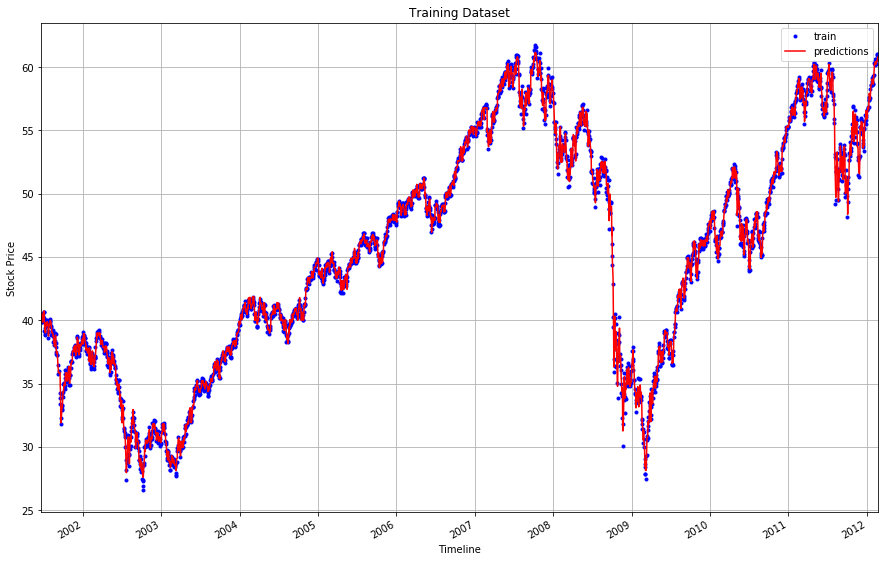

In [17]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 15, 10 # width 10, height 8

est_df = pd.DataFrame({'est': est, 
                       'date': train['date']})

ax = train.plot(x='date', y='adj_close', style='b.', grid=True)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'predictions'])
# ax.set_xlim([date(2002, 8, 1), date(2010, 5, 31)])
ax.set_xlabel("Timeline")
ax.set_ylabel("Stock Price")
ax.set_title('Training Dataset')

# Predict on dev set

In [18]:
# Do prediction on test set
est_scaled = model.predict(X_cv_scaled)
cv['est_scaled'] = est_scaled
cv['est'] = cv['est_scaled'] * cv['adj_close_std'] + cv['adj_close_mean']

# Calculate RMSE
rmse_bef_tuning = math.sqrt(mean_squared_error(y_cv, cv['est']))
print("RMSE on dev set = %0.3f" % rmse_bef_tuning)

# Calculate MAPE
mape_bef_tuning = get_mape(y_cv, cv['est'])
print("MAPE on dev set = %0.3f%%" % mape_bef_tuning)

RMSE on dev set = 0.668
MAPE on dev set = 0.603%


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'Validation Dataset')

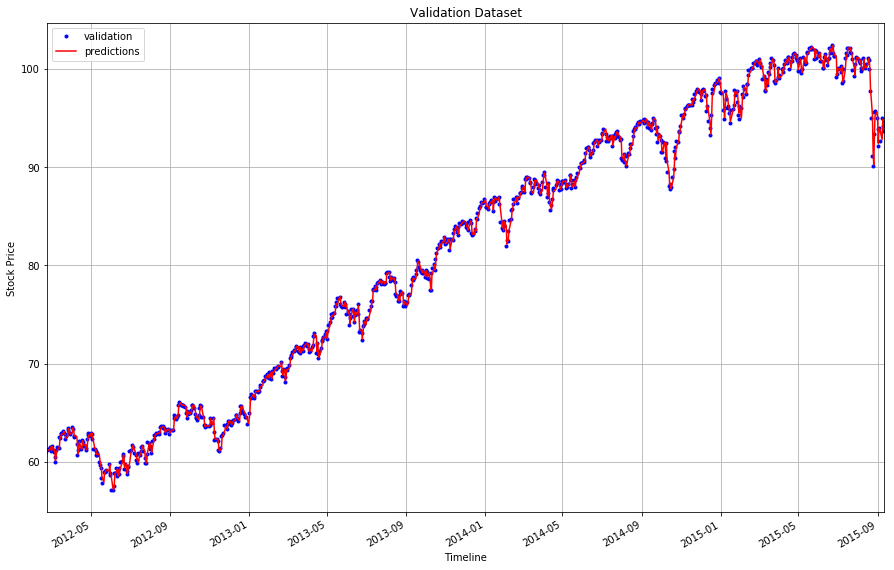

In [19]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 15, 10 # width 10, height 8

est_df = pd.DataFrame({'est': cv['est'], 
                       'y_cv': y_cv,
                       'date': cv['date']})

# ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='b.', grid=True)
# ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['validation', 'predictions'])
ax.set_xlabel("Timeline")
ax.set_ylabel("Stock Price")
ax.set_title("Validation Dataset")

# Tuning XGBoost - n_estimators (default=100) and max_depth (default=3)

In [20]:
param_label = 'n_estimators'
param_list = range(10, 310, 10)

param2_label = 'max_depth'
param2_list = [2, 3, 4, 5, 6, 7, 8, 9]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['adj_close_mean'],
                                     cv['adj_close_std'],
                                     seed=model_seed,
                                     n_estimators=param, 
                                     max_depth=param2, 
                                     learning_rate=learning_rate, 
                                     min_child_weight=min_child_weight, 
                                     subsample=subsample, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=gamma)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6


Minutes taken = 2.8786276022593182


n_estimators  max_depth      rmse  mape_pct
0              10          2  0.691035  0.613286
1              10          3  0.692911  0.614146
2              10          4  0.691799  0.612815
3              10          5  0.691296  0.612403
4              10          6  0.691422  0.612392
5              10          7  0.691547  0.612568
6              10          8  0.691634  0.612762
7              10          9  0.691847  0.613138
8              20          2  0.672162  0.603776
9              20          3  0.670942  0.602535
10             20          4  0.671765  0.602525
11             20          5  0.670099  0.601388
12             20          6  0.672023  0.602712
13             20          7  0.672084  0.603094
14             20          8  0.671223  0.602589
15             20          9  0.671738  0.603127
16             30          2  0.669707  0.603394
17             30          3  0.668139  0.601955
18             30          4  0.667891  0.600915
19             30          5  0.666855  0.600207
20             30          6  0.669108  0.601938
21             30          7  0.669516  0.601806
22             30          8  0.667085  0.600682
23             30          9  0.667820  0.601275
24             40          2  0.668871  0.603371
25             40          3  0.668103  0.602555
26             40          4  0.667299  0.601337
27             40          5  0.667265  0.601555
28             40          6  0.668898  0.602530
29             40          7  0.668976  0.601757
..            ...        ...       ...       ...
210           270          4  0.667056  0.601407
211           270          5  0.667226  0.601897
212           270          6  0.668752  0.602765
213           270          7  0.668807  0.602039
214           270          8  0.666198  0.600712
215           270          9  0.667033  0.601257
216           280          2  0.668603  0.604103
217           280          3  0.667105  0.602498
218           280          4  0.667058  0.601491
219           280          5  0.667257  0.601803
220           280          6  0.668819  0.602830
221           280          7  0.668835  0.602088
222           280          8  0.666219  0.600727
223           280          9  0.667021  0.601250
224           290          2  0.668631  0.604107
225           290          3  0.666915  0.602346
226           290          4  0.667066  0.601520
227           290          5  0.667333  0.601841
228           290          6  0.668769  0.602874
229           290          7  0.668783  0.602077
230           290          8  0.666220  0.600735
231           290          9  0.667011  0.601248
232           300          2  0.668746  0.604217
233           300          3  0.666890  0.602389
234           300          4  0.667011  0.601443
235           300          5  0.667408  0.601758
236           300          6  0.668804  0.602909
237           300          7  0.668791  0.602110
238           300          8  0.666211  0.600719
239           300          9  0.667002  0.601246

[240 rows x 4 columns]

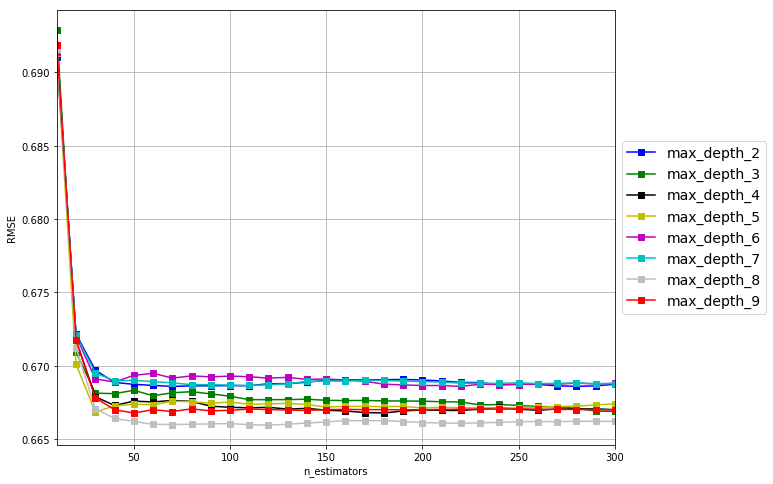

In [21]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [22]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
n_estimators_opt = temp['n_estimators'].values[0]
max_depth_opt = temp['max_depth'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
n_estimators_opt, max_depth_opt

min RMSE = 0.666
optimum params = 


(120, 8)

In [23]:
# Get optimum value for param and param2, using MAPE
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['n_estimators'].values[0], temp['max_depth'].values[0]

min MAPE = 0.600%
optimum params = 


(30, 5)

# Tuning XGBoost - learning_rate(default=0.1) and min_child_weight(default=1)

In [24]:
param_label = 'learning_rate'
param_list = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3]

param2_label = 'min_child_weight'
param2_list = range(5, 21, 1)

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['adj_close_mean'],
                                     cv['adj_close_std'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=param, 
                                     min_child_weight=param2, 
                                     subsample=subsample, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=gamma)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6


Minutes taken = 1.225349990526835


learning_rate  min_child_weight      rmse  mape_pct
0            0.001                 5  0.833905  0.716906
1            0.001                 6  0.833918  0.716926
2            0.001                 7  0.833845  0.716798
3            0.001                 8  0.833844  0.716803
4            0.001                 9  0.833896  0.716881
5            0.001                10  0.833901  0.716898
6            0.001                11  0.833887  0.716857
7            0.001                12  0.833888  0.716857
8            0.001                13  0.833876  0.716879
9            0.001                14  0.833882  0.716886
10           0.001                15  0.833879  0.716889
11           0.001                16  0.833884  0.716890
12           0.001                17  0.833865  0.716879
13           0.001                18  0.833868  0.716878
14           0.001                19  0.833865  0.716867
15           0.001                20  0.833867  0.716871
16           0.005                 5  0.731725  0.640586
17           0.005                 6  0.731786  0.640702
18           0.005                 7  0.731574  0.640372
19           0.005                 8  0.731576  0.640382
20           0.005                 9  0.731654  0.640513
21           0.005                10  0.731614  0.640522
22           0.005                11  0.731592  0.640412
23           0.005                12  0.731601  0.640392
24           0.005                13  0.731606  0.640479
25           0.005                14  0.731565  0.640498
26           0.005                15  0.731549  0.640517
27           0.005                16  0.731590  0.640572
28           0.005                17  0.731518  0.640530
29           0.005                18  0.731498  0.640512
..             ...               ...       ...       ...
82           0.200                 7  0.667603  0.601735
83           0.200                 8  0.669637  0.603130
84           0.200                 9  0.672490  0.605588
85           0.200                10  0.671771  0.605385
86           0.200                11  0.673751  0.606595
87           0.200                12  0.670609  0.603997
88           0.200                13  0.672874  0.606835
89           0.200                14  0.674574  0.607706
90           0.200                15  0.675238  0.607571
91           0.200                16  0.673855  0.606655
92           0.200                17  0.672878  0.605561
93           0.200                18  0.673237  0.605770
94           0.200                19  0.673719  0.607726
95           0.200                20  0.672956  0.605948
96           0.300                 5  0.670313  0.601429
97           0.300                 6  0.668318  0.602843
98           0.300                 7  0.667781  0.602150
99           0.300                 8  0.669946  0.603182
100          0.300                 9  0.673181  0.605188
101          0.300                10  0.670514  0.603295
102          0.300                11  0.670329  0.604380
103          0.300                12  0.670938  0.602950
104          0.300                13  0.671739  0.606854
105          0.300                14  0.669571  0.604141
106          0.300                15  0.670107  0.604593
107          0.300                16  0.670005  0.602965
108          0.300                17  0.669733  0.604211
109          0.300                18  0.667695  0.601784
110          0.300                19  0.668827  0.602229
111          0.300                20  0.668445  0.603518

[112 rows x 4 columns]

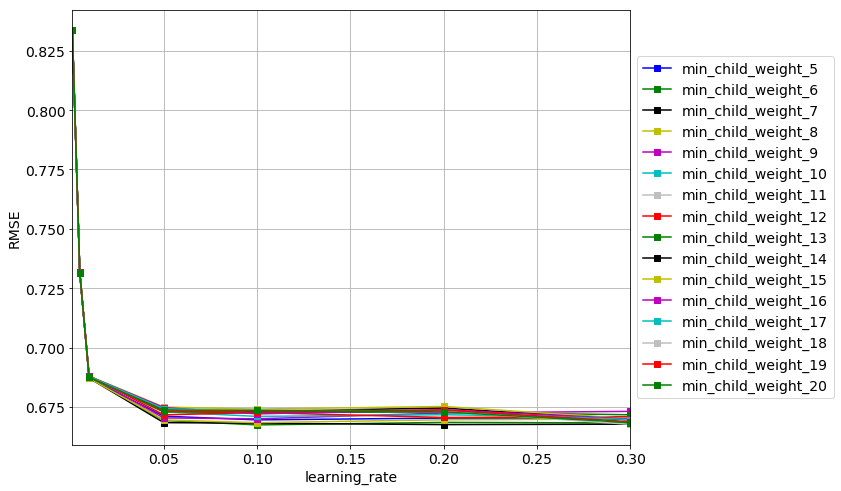

In [25]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [26]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
learning_rate_opt = temp['learning_rate'].values[0]
min_child_weight_opt = temp['min_child_weight'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
learning_rate_opt, min_child_weight_opt

min RMSE = 0.667
optimum params = 


(0.1, 6)

In [27]:
# Get optimum value for param and param2, using MAPE
# We will use RMSE to decide the final optimum params to use
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['learning_rate'].values[0], temp['min_child_weight'].values[0]

min MAPE = 0.600%
optimum params = 


(0.1, 6)

# Tuning XGBoost - subsample(default=1) and gamma(default=0)

In [28]:
param_label = 'subsample'
param_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'gamma'
param2_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['adj_close_mean'],
                                     cv['adj_close_std'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=learning_rate_opt, 
                                     min_child_weight=min_child_weight_opt, 
                                     subsample=param, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=param2)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6


Minutes taken = 1.177012825012207


subsample  gamma      rmse  mape_pct
0         0.1    0.1  0.703007  0.629442
1         0.1    0.2  0.700651  0.628057
2         0.1    0.3  0.694783  0.624046
3         0.1    0.4  0.691809  0.622620
4         0.1    0.5  0.697618  0.628107
5         0.1    0.6  0.695785  0.626009
6         0.1    0.7  0.698056  0.628572
7         0.1    0.8  0.701539  0.632195
8         0.1    0.9  0.701008  0.631749
9         0.1    1.0  0.695318  0.624920
10        0.2    0.1  0.674842  0.608311
11        0.2    0.2  0.678643  0.612471
12        0.2    0.3  0.681767  0.613835
13        0.2    0.4  0.678810  0.610268
14        0.2    0.5  0.681012  0.613084
15        0.2    0.6  0.677823  0.609784
16        0.2    0.7  0.683689  0.614095
17        0.2    0.8  0.686703  0.617841
18        0.2    0.9  0.685803  0.616451
19        0.2    1.0  0.687771  0.620127
20        0.3    0.1  0.676932  0.611397
21        0.3    0.2  0.674577  0.608690
22        0.3    0.3  0.673660  0.608406
23        0.3    0.4  0.676699  0.611317
24        0.3    0.5  0.671073  0.606332
25        0.3    0.6  0.673307  0.608494
26        0.3    0.7  0.676587  0.611260
27        0.3    0.8  0.673405  0.607983
28        0.3    0.9  0.677841  0.611981
29        0.3    1.0  0.673209  0.606332
..        ...    ...       ...       ...
70        0.8    0.1  0.667470  0.601375
71        0.8    0.2  0.668142  0.601691
72        0.8    0.3  0.667941  0.602059
73        0.8    0.4  0.667092  0.601894
74        0.8    0.5  0.668496  0.602354
75        0.8    0.6  0.668744  0.603031
76        0.8    0.7  0.669792  0.604311
77        0.8    0.8  0.669325  0.603509
78        0.8    0.9  0.668136  0.602553
79        0.8    1.0  0.666846  0.601410
80        0.9    0.1  0.666814  0.600813
81        0.9    0.2  0.667163  0.601198
82        0.9    0.3  0.667600  0.601459
83        0.9    0.4  0.668398  0.602203
84        0.9    0.5  0.667654  0.602059
85        0.9    0.6  0.667461  0.601799
86        0.9    0.7  0.665973  0.601125
87        0.9    0.8  0.670103  0.604598
88        0.9    0.9  0.668113  0.603069
89        0.9    1.0  0.665600  0.600722
90        1.0    0.1  0.668150  0.601796
91        1.0    0.2  0.668051  0.601634
92        1.0    0.3  0.668522  0.602414
93        1.0    0.4  0.667145  0.601730
94        1.0    0.5  0.667546  0.602106
95        1.0    0.6  0.669587  0.604244
96        1.0    0.7  0.669114  0.603545
97        1.0    0.8  0.669280  0.603930
98        1.0    0.9  0.669213  0.604195
99        1.0    1.0  0.668857  0.603597

[100 rows x 4 columns]

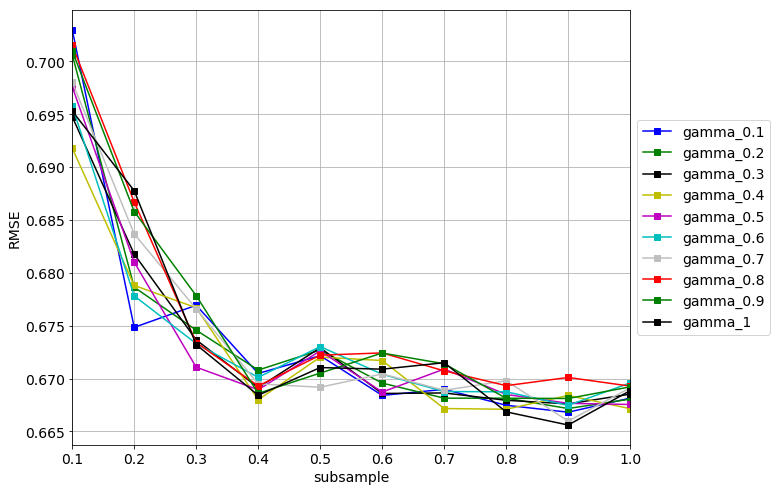

In [29]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [30]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
subsample_opt = temp['subsample'].values[0]
gamma_opt = temp['gamma'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
subsample_opt, gamma_opt

min RMSE = 0.666
optimum params = 


(0.9, 1.0)

In [31]:
# Get optimum value for param and param2, using MAPE
# We will use RMSE to decide the final optimum params to use
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['subsample'].values[0], temp['gamma'].values[0]

min MAPE = 0.601%
optimum params = 


(0.9, 1.0)

# Tuning XGBoost - colsample_bytree(default=1) and colsample_bylevel(default=1)

In [32]:
param_label = 'colsample_bytree'
param_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'colsample_bylevel'
param2_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['adj_close_mean'],
                                     cv['adj_close_std'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=learning_rate_opt, 
                                     min_child_weight=min_child_weight_opt, 
                                     subsample=subsample_opt, 
                                     colsample_bytree=param, 
                                     colsample_bylevel=param2, 
                                     gamma=gamma_opt)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6


Minutes taken = 0.30693313280741374


colsample_bytree  colsample_bylevel      rmse  mape_pct
0                0.5                0.5  0.804550  0.733825
1                0.5                0.6  0.804550  0.733825
2                0.5                0.7  0.784159  0.712476
3                0.5                0.8  0.784159  0.712476
4                0.5                0.9  0.774369  0.701011
5                0.5                1.0  0.781309  0.708714
6                0.6                0.5  0.837433  0.767588
7                0.6                0.6  0.775805  0.710647
8                0.6                0.7  0.775805  0.710647
9                0.6                0.8  0.762139  0.692420
10               0.6                0.9  0.748760  0.679323
11               0.6                1.0  0.753387  0.680763
12               0.7                0.5  0.742637  0.669627
13               0.7                0.6  0.742637  0.669627
14               0.7                0.7  0.701656  0.635494
15               0.7                0.8  0.692246  0.626325
16               0.7                0.9  0.675228  0.610216
17               0.7                1.0  0.744774  0.672338
18               0.8                0.5  0.761398  0.690467
19               0.8                0.6  0.748424  0.677673
20               0.8                0.7  0.736411  0.664450
21               0.8                0.8  0.720366  0.648208
22               0.8                0.9  0.698950  0.627688
23               0.8                1.0  0.695416  0.627847
24               0.9                0.5  0.743509  0.673865
25               0.9                0.6  0.715000  0.647322
26               0.9                0.7  0.702382  0.634104
27               0.9                0.8  0.675080  0.610122
28               0.9                0.9  0.674230  0.609276
29               0.9                1.0  0.693320  0.625057
30               1.0                0.5  0.753994  0.683730
31               1.0                0.6  0.730091  0.657457
32               1.0                0.7  0.715787  0.643730
33               1.0                0.8  0.686125  0.620089
34               1.0                0.9  0.678284  0.611535
35               1.0                1.0  0.665600  0.600722

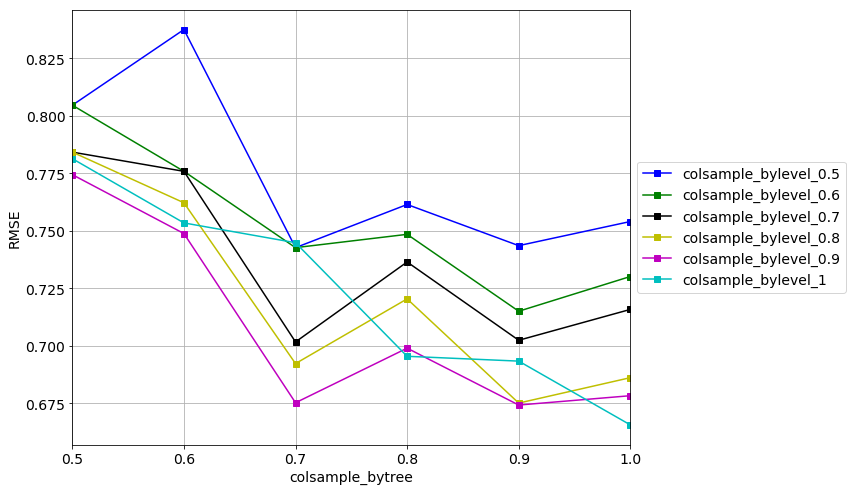

In [33]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [34]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
colsample_bytree_opt = temp['colsample_bytree'].values[0]
colsample_bylevel_opt = temp['colsample_bylevel'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
colsample_bytree_opt, colsample_bylevel_opt

min RMSE = 0.666
optimum params = 


(1.0, 1.0)

In [35]:
# Get optimum value for param and param2, using MAPE
# We will use RMSE to decide the final optimum params to use
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['colsample_bytree'].values[0], temp['colsample_bylevel'].values[0]

min MAPE = 0.601%
optimum params = 


(1.0, 1.0)

# Tuned params

In [36]:
d = {'param': ['n_estimators', 'max_depth', 'learning_rate', 'min_child_weight', 'subsample', 'colsample_bytree', 'colsample_bylevel', 'gamma', 'rmse', 'mape_pct'],
     'original': [n_estimators, max_depth, learning_rate, min_child_weight, subsample, colsample_bytree, colsample_bylevel, gamma, rmse_bef_tuning, mape_bef_tuning],
     'after_tuning': [n_estimators_opt, max_depth_opt, learning_rate_opt, min_child_weight_opt, subsample_opt, colsample_bytree_opt, colsample_bylevel_opt, gamma_opt, error_rate['rmse'].min(), error_rate['mape_pct'].min()]}
tuned_params = pd.DataFrame(d)
tuned_params = tuned_params.round(3)
tuned_params

param  original  after_tuning
0       n_estimators   100.000       120.000
1          max_depth     3.000         8.000
2      learning_rate     0.100         0.100
3   min_child_weight     1.000         6.000
4          subsample     1.000         0.900
5   colsample_bytree     1.000         1.000
6  colsample_bylevel     1.000         1.000
7              gamma     0.000         1.000
8               rmse     0.668         0.666
9           mape_pct     0.603         0.601

# Final model

In [37]:
rmse, mape, est = train_pred_eval_model(X_train_cv_scaled, 
                             y_train_cv_scaled, 
                             X_sample_scaled, 
                             y_sample, 
                             test['adj_close_mean'],
                             test['adj_close_std'],
                             seed=model_seed,
                             n_estimators=n_estimators_opt, 
                             max_depth=max_depth_opt, 
                             learning_rate=learning_rate_opt, 
                             min_child_weight=min_child_weight_opt, 
                             subsample=subsample_opt, 
                             colsample_bytree=colsample_bytree_opt, 
                             colsample_bylevel=colsample_bylevel_opt, 
                             gamma=gamma_opt)

# Calculate RMSE
print("RMSE on test set = %0.3f" % rmse)

# Calculate MAPE
print("MAPE on test set = %0.3f%%" % mape)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


RMSE on test set = 1.032
MAPE on test set = 0.596%


Text(0.5, 1.0, 'Testing Performance')

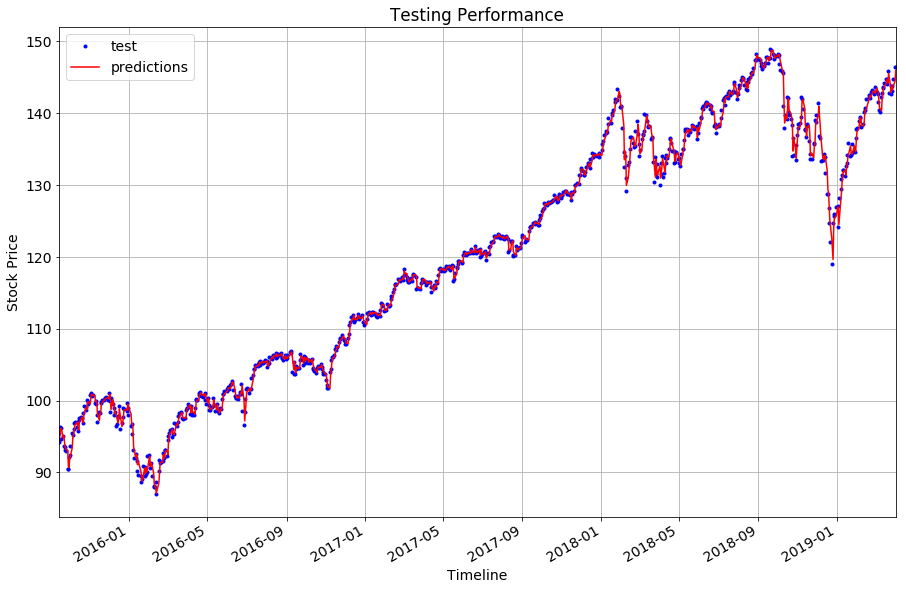

In [38]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 15, 10 # width 10, height 8

est_df = pd.DataFrame({'est': est, 
                       'y_sample': y_sample,
                       'date': test['date']})

# ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
# ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='b.', grid=True)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['test', 'predictions'])
# ax.set_xlim([date(2015, 9, 14), date(2019, 4, 2)])
ax.set_xlabel("Timeline")
ax.set_ylabel("Stock Price")
ax.set_title("Testing Performance")
# est_df.tail()


In [39]:
train.head()

date  adj_close  volume  month  range_hl  range_oc  order_day  \
3 2001-06-20  40.165779  476000      6  0.700001 -0.674999          3   
4 2001-06-21  40.488239  240400      6  0.849998 -0.500000          4   
5 2001-06-22  40.230259  180600      6  0.575001  0.310002          5   
6 2001-06-25  39.971649   30400      6  0.800000  0.459999          6   
7 2001-06-26  39.867470  146600      6  0.745003 -0.445000          7   

   adj_close_lag_1  range_hl_lag_1  range_oc_lag_1  ...  range_oc_lag_3  \
3        39.746536        0.930000        0.685002  ...       -0.240002   
4        40.165779        0.700001       -0.674999  ...        0.504998   
5        40.488239        0.849998       -0.500000  ...        0.685002   
6        40.230259        0.575001        0.310002  ...       -0.674999   
7        39.971649        0.800000        0.459999  ...       -0.500000   

   volume_lag_3  adj_close_mean  adj_close_std  range_hl_mean  range_hl_std  \
3     1067400.0             NaN            NaN            NaN           NaN   
4      282600.0       40.165779            NaN       0.700001           NaN   
5     1777600.0       40.327009       0.228014       0.774999      0.106064   
6      476000.0       40.294759       0.170632       0.708333      0.137688   
7      240400.0       40.230049       0.258295       0.741666      0.146485   

   range_oc_mean  range_oc_std    volume_mean     volume_std  
3            NaN           NaN            NaN            NaN  
4      -0.674999           NaN  476000.000000            NaN  
5      -0.587499      0.123743  358200.000000  166594.357648  
6      -0.288332      0.525508  299000.000000  156175.414198  
7       0.090000      0.516430  150466.666667  108194.331336  

[5 rows x 27 columns]

In [40]:
train.tail()

date  adj_close   volume  month  range_hl  range_oc  order_day  \
2683 2012-02-15  60.268047  2022900      2  0.819999  0.559998       2683   
2684 2012-02-16  60.988400  1601500      2  0.970002 -0.820000       2684   
2685 2012-02-17  61.075211  2093300      2  0.339997  0.110000       2685   
2686 2012-02-21  61.049152  1525900      2  0.550003  0.240006       2686   
2687 2012-02-22  60.858238  1781800      2  0.420006  0.089996       2687   

      adj_close_lag_1  range_hl_lag_1  range_oc_lag_1  ...  range_oc_lag_3  \
2683        60.528423        0.489998       -0.040001  ...       -0.079995   
2684        60.268047        0.819999        0.559998  ...       -0.019996   
2685        60.988400        0.970002       -0.820000  ...       -0.040001   
2686        61.075211        0.339997        0.110000  ...        0.559998   
2687        61.049152        0.550003        0.240006  ...       -0.820000   

      volume_lag_3  adj_close_mean  adj_close_std  range_hl_mean  \
2683     1365200.0       60.432940       0.244407       0.409999   
2684     1499600.0       60.470554       0.180663       0.570000   
2685     1875500.0       60.594957       0.364756       0.760000   
2686     2022900.0       60.777219       0.443087       0.709999   
2687     1601500.0       61.037588       0.044546       0.620001   

      range_hl_std  range_oc_mean  range_oc_std   volume_mean     volume_std  
2683      0.075499      -0.046664      0.030549  1.580100e+06  264502.759910  
2684      0.221132       0.166667      0.340781  1.799333e+06  269836.512231  
2685      0.245562      -0.100001      0.691953  1.833300e+06  213846.019369  
2686      0.329092      -0.050001      0.703775  1.905900e+06  265957.816204  
2687      0.320782      -0.156665      0.578131  1.740233e+06  308092.345463  

[5 rows x 27 columns]